# 1 Customized Public Functions

## 1.1 Function for Calculating the optimal pre-season length for specified variables

In [ ]:
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from joblib import Parallel, delayed
from scipy.signal import detrend


def par_corr_npy(data, threshold=0.5):
    rows, cols = data.shape
    data = data[~np.isnan(data).any(axis=1)]
    if data.shape[0] < rows*threshold:
        return np.full(cols-1, np.nan)
    
    data = detrend(data, axis=0)
    # data = zscore(data, axis=0)
    corr_matrix = np.corrcoef(data, rowvar=False)
    inv_matrix = np.linalg.inv(corr_matrix)
    r = np.array([-inv_matrix[0, col] / np.sqrt(inv_matrix[0, 0] * inv_matrix[col, col]) for col in range(1, cols)])
    return r


def partial_corr(x, y, threshold=0.5, n_jobs=-1):
    data = np.concatenate([y[..., np.newaxis], x], axis=-1) # (660000, 21, 4)
    result = np.array(Parallel(n_jobs=n_jobs)(delayed(par_corr_npy)(data[i], threshold) for i in range(data.shape[0]))) # (660000, 3)
    return result



def get_opl(y:np.ndarray, x:np.ndarray, **kwargs):
    """
    Calculate the optimal pre-season length for specified variables.

    Parameters:
    - y: np.ndarray, shape (rows, cols, years, ) 
      Target variable data over the years. such as phenological data at an annual scale.

    - x: np.ndarray, shape (rows, cols, months, xvars)
      Explanatory variables data at a monthly scale, covering one more year than y data (months = 12 * (years + 1)).

    Keyword Arguments (kwargs):
    - n_jobs: int, default --> mp.cpu_count()
      number of jobs to run in parallel. 
    
    - max_month: int, default 6
      Maximum pre-season length calculated forward from the current month.


    Returns: 
    - for multiple data (eg. x.ndim == 4)
      result: np.ndarray, shape (rows, cols, xvars) the value of opl for each variable.
    """
    n_jobs = kwargs.get('n_jobs', -1)
    max_month = kwargs.get('max_month', 6)
    threshold = kwargs.get('threshold', 0.5)
    
    # Shape adaptation
    y = y.squeeze()
    x = x.squeeze()
    if x.ndim == 2:
        x = x[np.newaxis, np.newaxis, :, :]  # (1, 1, months, xvars)
        y = y[np.newaxis, np.newaxis, :]  # (1, 1, years)

    elif x.ndim == 3:
        x = x[np.newaxis, :, :, :]  # (1, cols, months, xvars)
        y = y[np.newaxis, :, :]  # (1, cols, years)
        
    
    rows, cols, months, xvars = x.shape
    _, _, years = y.shape

    mask_y = np.sum(~np.isnan(y), axis=2) >= years*threshold 
    mask_x = np.sum(~np.isnan(x), axis=2) >= months*threshold
    mask_x = np.sum(mask_x, axis=2) == xvars
    mask = mask_y & mask_x
    y = y[mask]
    x = x[mask]

    # Get the month of the multi-year average phenological period
    y_mean = np.nanmean(y, axis=-1)
    y_mean = np.array([(datetime(2023, 1, 1) + timedelta(days=int(round(day)))).month for day in y_mean])
    y_mean = np.expand_dims(y_mean, axis=-1).astype(int)

    indices1 = np.arange(years) * 12 + y_mean - 1
    indices0 = np.arange(x.shape[0])[:, np.newaxis]

    x_list = [x[:, 12-i:-i if i!= 0 else None, :] for i in range(max_month)]
    x_list = [np.mean(x_list[:i+1], axis=0)[indices0, indices1, :] for i in range(max_month)]

    result = [partial_corr(x, y, threshold, n_jobs) for x in tqdm(x_list)]
    result = np.abs(np.array(result))
    result = np.argmax(result, axis=0)
    
    result_mask = np.full((rows, cols, xvars), np.nan)
    result_mask[mask] = result
    result_mask = result_mask.squeeze()
    
    return result_mask



## 1.2 Function for Calculating the Mean Value of Variables During the Pre-season Period

In [ ]:
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from joblib import Parallel, delayed

    
def single_mean(x, opl, pheno):
    """
    x: shape (months, )
    opl: number
    pheno: number
    """
    k_indices = np.arange(12, len(x), 12) # (months//12-1, )
    start_indices = (k_indices + pheno - opl - 1).astype(int) # (months//12-1, )
    end_indices = (k_indices + pheno).astype(int) # (months//12-1, )
    mask = (np.arange(len(x)) >= start_indices[:, np.newaxis]) & (np.arange(len(x)) < end_indices[:, np.newaxis])
    x_masked = np.where(mask, x, np.nan) 
    resarr = np.nanmean(x_masked, axis=1) # shape (months//12-1, )
    
    return resarr


def seasonal_mean(x_arr: np.ndarray, opl_arr: np.ndarray, pheno_arr: np.ndarray):
    """
    Calculate pre-seasonal mean from input arrays.

    Parameters:
    - x_arr (np.ndarray): Climate variable array (months, rows, cols), where months is a multiple of 12.
    - opl_arr (np.ndarray): The optimal preseason length (rows, cols).
    - pheno_arr (np.ndarray): Phenological dates (rows, cols), typically multi-year average in day of year (1-365) or month (1-12).

    Returns:
    - result (np.ndarray): Pre-seasonal mean (months//12-1, rows, cols).

    """

    if np.nanmax(pheno_arr) > 12: # if the value of pheno_arr is the "day of year" (1-365), then convert it to the month
        pheno_arr[~np.isnan(pheno_arr)] = np.array([(datetime(2023, 1, 1) + timedelta(days=eos - 1)).month for eos in pheno_arr[~np.isnan(pheno_arr)]])

    months, rows, cols = x_arr.shape
 
    nn_indices = np.where(~np.isnan(opl_arr) & ~np.isnan(pheno_arr)) # nn_indices, means the indices of non-NaN elements
    nn_opl = opl_arr[nn_indices] 
    nn_pheno = pheno_arr[nn_indices] 
    nn_x = x_arr[:, nn_indices[0], nn_indices[1]]

    # slice the data
    args_list = [(nn_x[:, i], nn_opl[i], nn_pheno[i]) for i in range(nn_opl.shape[0])]
    res = np.array(Parallel(n_jobs=-1)(delayed(single_mean)(x, opl, pheno) for x, opl, pheno in tqdm(args_list)))
    result = np.full((months//12-1, rows, cols), np.nan)
    result[:, nn_indices[0], nn_indices[1]] = res.swapaxes(0, 1)

    return result
 

## 1.3 Geographically Weighted Regression Function

In [ ]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy.stats import zscore, t
from phenology.utils import remove_outliers


def parallel_gwr(df, x_names, y_name):
    """
    Conducts parallel Geographically Weighted Regression (GWR) analysis.

    Parameters:
    - df (DataFrame): The input DataFrame containing spatial data.
    - x_names (list): A list of column names representing the independent variables.
    - y_name (str): The column name representing the dependent variable.

    Returns:
    - res (DataFrame): A DataFrame containing the GWR results.
    """

    # Remove outliers and drop NaN values
    df[x_names+[y_name]] = df[x_names+[y_name]].apply(remove_outliers)
    df = df.dropna()
    
    coords = list(zip(df['longitude'], df['latitude']))
    res = df[['longitude', 'latitude']]
    df = df.apply(zscore)

    # Extract independent and dependent variables
    y = df[[y_name]].values
    x = df[x_names].values

    try:
        # Bandwidth selection and Fit GWR model
        gwr_selector = Sel_BW(coords, y, x)
        gwr_bw = gwr_selector.search(search_method='golden_section', criterion='AICc')
        gwr_results = GWR(coords, y, x, gwr_bw, fixed=False, kernel='bisquare', constant=True, spherical=True).fit()

        # Extract regression parameters and p-values
        r_values = gwr_results.params[:, 1]
        t_values = gwr_results.tvalues[:, 1]
        p_values = 2 * (1 - t.cdf(np.abs(t_values), df=gwr_results.df_resid))

        res['n'] = int(gwr_bw)
        res[['r', 't-val', 'p-val']] = np.array([r_values, t_values, p_values]).T # (232, 3)

        return res
    
    except Exception as e:
        print(e)

## 1.4 Other Auxiliary Functions

### 1.4.1 Function for Outlier Removal

In [ ]:
import numpy as np
import xarray as xr


def remove_outliers(data, threshold=3):
    """
    Function to remove outliers from a given data array.

    Parameters:
    - data: One-dimensional or multi-dimensional data array, can be a pandas Series, NumPy array, or xarray.DataArray.
    - threshold: Threshold for outliers in terms of the data standard deviation. Default is 3.

    Returns:
    - Processed data array with outliers beyond the threshold replaced with NaN.

    Note:
    - For NumPy arrays, the function directly modifies the input array, replacing outliers with NaN.
    - For xarray.DataArray, a new array is generated where outliers are replaced with NaN, and the original array remains unaffected.
    - If the input is a pandas Series, a new Series is generated with outliers replaced with NaN, and the original Series remains unaffected.

    """
    
    # Calculate the standard deviation, mean, and center the data
    data_std = np.nanstd(data)
    data_mean = np.nanmean(data)
    data_centered = np.abs(data - data_mean)
    
    # Remove outliers based on the threshold and data type
    if isinstance(data, xr.DataArray):
        data = xr.where(data_centered > threshold*data_std, np.nan, data)
    else:
        data[data_centered > threshold*data_std] = np.nan

    return data

### 1.4.2 Function for Converting DataFrame with Coordinate Information to Vector Shapefile

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point

def df2shp(df, file_path, lon_name='longitude', lat_name='latitude'):
    """
    Converts a DataFrame with longitude and latitude columns to a shapefile.

    Parameters:
    - df (DataFrame): The input DataFrame containing longitude and latitude data.
    - file_path (str): The file path where the shapefile will be saved.
    - lon_name (str, optional): The name of the longitude column in the DataFrame. Default is 'longitude'.
    - lat_name (str, optional): The name of the latitude column in the DataFrame. Default is 'latitude'.

    Returns:
    - None
    """
    # Check if there are longitudes greater than 180 degrees
    longs = df[lon_name].values
    if np.nanmax(np.abs(longs)) > 190:
        df1 = df.copy()[df[lon_name] > 180]
        df1[lon_name] = df1[lon_name] - 360
        df2 = df.copy()[df[lon_name] <= 180]
        df = pd.concat([df1, df2], axis=0)
        
    # Convert longitude and latitude columns to Point geometry
    geometry = [Point(xy) for xy in zip(df[lon_name], df[lat_name])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.crs = CRS.from_epsg(4326)

    # Save the GeoDataFrame as a shapefile
    gdf.to_file(file_path)


### 1.4.3 Function for Multiple Hypothesis Testing

In [ ]:
import numpy as np
from statsmodels.stats import multitest as multi



def multicorrect(df, p_name='p-val', method='fdr_bh'):
    """
    Perform multiple testing correction on p-values in a DataFrame.

    Parameters:
    - df (DataFrame): The input DataFrame containing p-values.
    - p_name (str, optional): The name of the column containing p-values. Default is 'p-val'.
    - method (str, optional): The multiple testing correction method. Default is 'fdr_bh'.
    
    Returns:
    - df (DataFrame): The input DataFrame with corrected p-values added as a new column.
    """
    # Extract p-values and remove NaN values
    p_arr = df[p_name].values
    mask = ~np.isnan(p_arr)
    nn_p = p_arr[mask]
    
    # Perform multiple testing correction
    _, corrected_p_values, _, _ = multi.multipletests(nn_p, method=method)
    
    # Fill in NaN values with corrected p-values
    p_corrected = np.full(mask.shape, np.nan)
    p_corrected[mask] = corrected_p_values
    
    # Add corrected p-values as a new column to the DataFrame
    df[f'{p_name}-corrected'] = p_corrected
    
    return df


# 2 Analysis of Biodiversity Effects on ST

## 2.1 Global Analysis

In [ ]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import zscore
from phenology.utils import remove_outliers


def regress(x_train, y_train):      
    """
    Perform ordinary least squares (OLS) regression.

    Parameters:
    - x_train (ndarray): Independent variables.
    - y_train (ndarray): Dependent variable.

    Returns:
    - model (statsmodels.regression.linear_model.RegressionResultsWrapper): OLS regression model.
    """
    # Add a constant term to the independent variables
    x_train = sm.add_constant(x_train)
    # Fit the OLS model
    model = sm.OLS(y_train, x_train).fit()
    return model


def seq_regress(x_train, y_train):
    """
    Perform sequential residual regression.

    Parameters:
    - x_train (ndarray): Independent variables.
    - y_train (ndarray): Dependent variable.

    Returns:
    - model (statsmodels.regression.linear_model.RegressionResultsWrapper): Sequential residual regression model.
    """
    # Obtain residuals from the first regression and replace the first independent variable with them
    x_train[:, 0] = regress(x_train[:, 1:], x_train[:, 0]).resid
    # Fit the sequential residual regression model
    model = regress(x_train, y_train)
    return model


def seq_pcorr(df, y, x_list):
    """
    Perform sequential partial correlation analysis.

    Parameters:
    - df (DataFrame): Input DataFrame containing the variables.
    - y (str): Dependent variable.
    - x_list (list): List of independent variables.

    Returns:
    - result_df (DataFrame): DataFrame containing the sequential partial correlation results.
    """
    res_list = []
    for var in x_list:
        # Perform partial correlation for each variable with other variables
        res = pg.partial_corr(df, y=y, x=var, covar=[item for item in x_list if item != var])
        res['var'] = var
        res_list.append(res)
    result_df = pd.concat(res_list, axis=0)
    return result_df


if __name__ == '__main__':
    # Load and preprocess the data
    df = pd.read_csv('./Data/data_bio_evenness.csv')
    df = df[df['pval'] <= 0.05]
    var_list = ['st', 'bio', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem', 'evenness']
    df = df[var_list].dropna().apply(remove_outliers).dropna().apply(zscore).dropna()

    # Perform sequential partial correlation and regression analyses
    df_pcorr = seq_pcorr(df, 'st', var_list[1:])[['var', 'r', 'p-val']].reset_index(drop=True).rename(columns={'r':'r_pcorr', 'p-val':'p_pcorr'})
    df_res = seq_regress(df[var_list[1:]].values, df['st'].values)
    df_res = pd.DataFrame([var_list[1:], df_res.params[1:], df_res.pvalues[1:]], columns=var_list[1:], index=['var', 'r_seqols', 'p_seqols']).T.reset_index(drop=True)

    # Merge the results
    df_merge = df_pcorr.merge(df_res, on='var')
    display(df_merge)


,var,r_pcorr,p_pcorr,r_seqols,p_seqols,shapvalue,importance,mse,r2,mean
0,bio,-0.262760,9.980861e-24,-0.278805,9.980861e-24,0.292846,0.225915,0.077531,0.922469,0.259380
1,t2m,-0.144884,4.543490e-08,-0.217337,7.664925e-10,0.219018,0.146995,0.077531,0.922469,0.183006
2,ssrd,-0.062562,1.871851e-02,-0.091209,2.413683e-04,0.098177,0.115849,0.077531,0.922469,0.107013
3,dem,0.153479,6.771894e-09,0.231735,2.177791e-13,0.079692,0.111540,0.077531,0.922469,0.095616
4,nitrogen,0.076343,4.099872e-03,0.113229,1.011166e-03,0.065658,0.067425,0.077531,0.922469,0.066541
5,tp,0.129576,1.032539e-06,0.095547,2.095418e-03,0.064758,0.072030,0.077531,0.922469,0.068394
6,fa,0.010231,7.008857e-01,0.000212,9.945998e-01,0.063005,0.077574,0.077531,0.922469,0.070289
7,swvl1,-0.046267,8.221979e-02,-0.102840,3.290200e-04,0.057911,0.087687,0.077531,0.922469,0.072799
8,soc,-0.043522,1.021019e-01,-0.051616,1.177391e-01,0.042463,0.058426,0.077531,0.922469,0.050445
9,evenness,0.045404,8.810348e-02,0.078920,9.864225e-04,0.016472,0.036559,0.077531,0.922469,0.026516


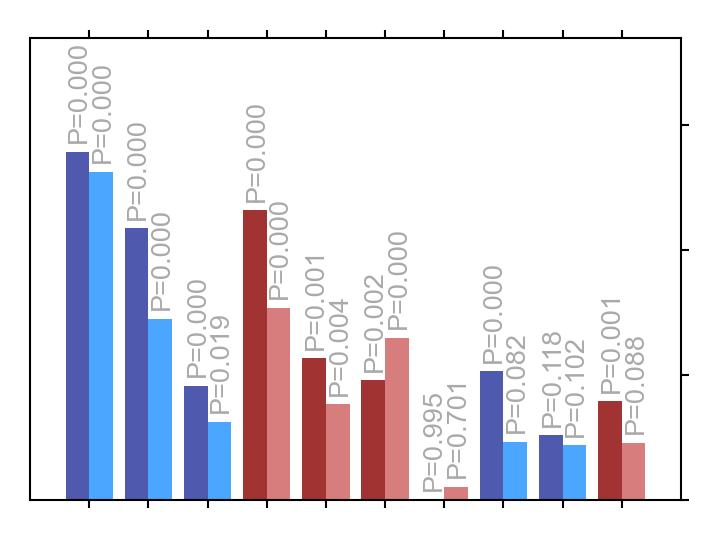

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def plt_fig1b(df, out_fig_name=None, figsize=(2.8, 2), y_lime = 0.42, y_ticks=[0, 0.1, 0.2, 0.3], dx=0):

    plt.subplots(figsize=figsize, dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams["axes.edgecolor"] = "black"  
    plt.rcParams['svg.fonttype'] = 'none'

    ols_est = df['r_seqols'].values
    ols_pval = df["p_seqols"].values
    ols_colors = ["darkred" if number > 0 else (35/255, 48/255, 154/255) for number in ols_est]
    ols_data = zip(np.arange(len(ols_est))-0.2, np.abs(ols_est), ols_pval, ols_colors)


    pcorr_est = df['r_pcorr'].values
    pcorr_pval = df['p_pcorr'].values
    pcorr_colors = ["indianred" if number > 0 else 'dodgerblue' for number in pcorr_est]
    pcorr_data = zip(np.arange(len(pcorr_est))+0.2, np.abs(pcorr_est), pcorr_pval, pcorr_colors)

    for zip_data in [ols_data, pcorr_data]:
        
        for p, estimate, p_value, color in zip_data:
            plt.bar(p, np.abs(estimate), width=0.4, color=color, alpha=0.8, zorder=0)
            text = "P={:.3f}".format(p_value)
            plt.text(p+dx, np.abs(estimate) + y_lime*0.02, text, ha='center', va='bottom', fontsize=6.5, color='darkgray', rotation=90)

    plt.xlim(-1, 10)
    plt.ylim(0, y_lime)
    plt.xticks(range(len(pcorr_est)), [])
    plt.yticks(y_ticks, [])
    plt.gca().yaxis.set_label_position('right')
    plt.tick_params(axis='x', which='both', labeltop=True, top=True)
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True, right=True, left=False)
    plt.tick_params(axis='both', direction='out', length=2, width=0.5)
    
    for spine in plt.gca().spines.values(): spine.set_linewidth(0.5)
    if out_fig_name is not None:
        plt.savefig(out_fig_name, bbox_inches="tight", transparent=True, pad_inches=0)
    plt.show()


if __name__ == '__main__':

    df = pd.read_csv('./Result_v2/rfr/rfr_importance$shapvalue&pcorr&seqols.csv')
    display(df)
    plt_fig1b(df, y_lime=0.37, dx=0.03)
    

## 2.2 Zonal Analysis

In [ ]:
import joblib
import pandas as pd
import pingouin as pg
from glob import glob
from scipy.stats import zscore
from phenology.utils import remove_outliers
import statsmodels.stats.multitest as multi

def partial_zone(input_file, y, x, covar, zone_name):
    """
    Perform partial correlation analysis for a specific zone.

    Parameters:
    - input_file (str): Path to the input CSV file containing data for the zone.
    - y (str): Dependent variable.
    - x (str): Independent variable.
    - covar (list): List of covariates.
    - zone_name (str): Name of the zone (e.g., 'lct', 'biome', 'beck').

    Returns:
    - nrcp (DataFrame): Partial correlation results for the zone.
    """
    try:
        value = int(input_file.split("_")[-1].split(".")[0])
        abbr = dict_zone[zone_name][value]
        # Read data from CSV file and select relevant columns
        df = pd.read_csv(input_file)[[y, x]+covar].dropna()
        # Remove outliers, standardize the data, and drop NaN values
        df = df.apply(remove_outliers).dropna().apply(zscore).dropna()
        # Perform partial correlation analysis
        nrcp = pg.partial_corr(df, x=x, y=y, covar=covar)
        nrcp["abbr"] = abbr
        nrcp["value"] = value
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")
    return nrcp



if __name__ == '__main__':
    # Define variables
    y = "st"
    x = "bio"
    covar = ['t2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem']
    dict_zone = joblib.load("./Data/zonedata/dict_zone.dict") # Load the dictionary mapping zone IDs to names

    # Loop through zone names
    for zone_name in ['lct', 'biome', 'beck']:
        csv_list = glob(f"./Data/Zone/data_{zone_name}/*.csv")
        df_res = pd.concat([partial_zone(csv, y, x, covar, zone_name) for csv in csv_list], axis=0).dropna()
        df_res = df_res.sort_values(by='p-val')[["value", "abbr", "n", "r", "CI95%", "p-val"]].reset_index(drop=True)
        # Perform multiple testing correction
        df_res["p-val"] = multi.multipletests(df_res["p-val"].values, method='fdr_bh')[1]
        df_res["p_val_round"] = df_res["p-val"].round(3)
        df_res.to_csv(f"./Result/Zone/{zone_name}.csv", index=False)

        

,value,abbr,n,r,CI95%,p-val,p_val_round
0,4,DBF,60869,-0.228275,[-0.24 -0.22],0.000000e+00,0.000
1,8,WSA,56585,-0.179568,[-0.19 -0.17],0.000000e+00,0.000
2,9,SAV,18918,-0.223785,[-0.24 -0.21],1.077547e-212,0.000
3,12,CRO,14452,-0.177484,[-0.19 -0.16],4.315718e-102,0.000
4,14,CNV,5370,-0.252293,[-0.28 -0.23],2.684358e-78,0.000
5,10,GRA,8992,-0.133260,[-0.15 -0.11],1.300765e-36,0.000
6,5,MF,25311,-0.058717,[-0.07 -0.05],1.408888e-20,0.000
7,2,EBF,2323,-0.081760,[-0.12 -0.04],1.128238e-04,0.000
8,13,URB,504,-0.170998,[-0.26 -0.08],1.585949e-04,0.000
9,11,WET,179,-0.148714,[-0.29 0. ],5.745348e-02,0.057


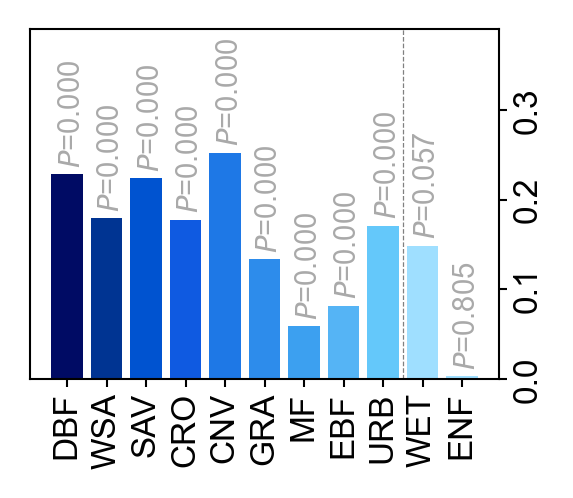

In [3]:
# Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plt_fig1f(data, color_lct, out_fig_name=None, y_lime=0.39, y_ticks=[0.0, 0.1, 0.2, 0.3], dx=0.12):

    estimates = data['r'].values
    p_values = data['p-val'].values
    n_values = data['n'].values
    color_list = [(r / 255, g / 255, b / 255) for r, g, b in color_lct]

    plt.rcParams['font.sans-serif']=['Arial'] 
    plt.rcParams['axes.unicode_minus']=False 
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['svg.fonttype'] = 'none'
    plt.subplots(figsize=(2.0177, 1.5133), dpi=300)
    for spine in plt.gca().spines.values(): spine.set_linewidth(0.5)
    
    for i, (estimate, p_value, color, n) in enumerate(zip(estimates, p_values, color_list, n_values)):
        # text = '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
        text = r"$\mathit{P}$" + "={:.3f}".format(p_value)
        plt.bar(i, np.abs(estimate), color=color, alpha=1, zorder=0)
        plt.text(i+dx, np.abs(estimate) + y_lime* 0.02, text, ha='center', va='bottom', fontsize=7, color='darkgray', rotation=90)
       
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True, right=True, left=False, rotation=90)
    plt.tick_params(axis='both', direction='out', length=2, width=0.5)
    plt.tick_params(axis='both', which='major', pad=1.15)

    plt.axvline(x=len(estimates)-sum(data['p-val'] > 0.05) - 0.5, color='gray', linestyle='--', zorder=0, linewidth=0.3)
    plt.xticks(np.arange(len(estimates)), [abbr.upper() for abbr in data['abbr']], rotation=90, ha='center')
    plt.yticks(y_ticks, va='center')
    plt.ylim(0, y_lime)
   
    if out_fig_name is not None:
        plt.savefig(out_fig_name, bbox_inches="tight", transparent=True, pad_inches=0)
        
    plt.show()
    

if __name__ == '__main__':

    colors = [(0, 11, 100),
              (0, 52, 146), 
              (0, 83, 208), 
              (15, 90, 225), 
              (30, 120, 230), 
              (45, 140, 235), 
              (60, 160, 240), 
              (85, 180, 245), 
              (100, 200, 250), 
              (159, 223, 255), 
              (159, 223, 255)
              ]

    df = pd.read_csv("./Result/Zone/lct.csv")
    display(df)
    plt_fig1f(df, colors, y_lime=0.39, y_ticks=[0.0, 0.1, 0.2, 0.3], dx=0.12)


## 2.3 Local Analysis

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
from tqdm import tqdm
from math import radians
from mgwr.sel_bw import Sel_BW
from scipy.stats import zscore
from utils import multicorrect
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import haversine_distances
from phenology.utils import remove_outliers, dfsummary, df2shp, multicorrect



def parallel_hd(x, y, bw):
    """
    Calculates the haversine distances between each point in x and all points in y.

    Parameters:
    - x (ndarray): Array of coordinates for the current group.
    - y (ndarray): Array of all coordinates.
    - bw (int): Number of nearest points to consider.

    Returns:
    - res (ndarray): Indices of the nearest points in y for each point in x.
    """
    res = haversine_distances(x, y)
    res = np.argsort(res, axis=1)
    res = res[:, :bw]
    return res



def parallel_partial(data_i):
    """
    Performs partial correlation analysis for a subset of data.

    Parameters:
    - data_i (ndarray): Subset of data.

    Returns:
    - res (DataFrame): Partial correlation results.
    """

    x = 'st'
    y = 'bio'
    id = data_i[0,0]
    covar = ['t2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem']
    var_list = ['id', 'st', 'bio', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem', 'latitude', 'longitude']
    df = pd.DataFrame(data_i, columns=var_list)[[y, x]+covar]
    df = df.apply(remove_outliers).dropna(axis=0)
    df = df.iloc[:bw, :].apply(zscore)
    res = pg.partial_corr(df, x, y, covar)
    res['id'] = id
    return res



if __name__ == '__main__':

    # Get the optimal bandwidth
    df = pd.read_csv('./Data/data_bio_evenness.csv')
    df = df[(df['pval'] <= 0.05)].dropna()
    coords = list(zip(df['latitude'], df['longitude']))

    y = df[['st']].values
    x = df[['bio', 't2m', 'tp', 'ssrd', 'swvl1', 'soc', 'nitrogen', 'fa', 'dem']].values
    bw_selector = Sel_BW(coords, y, x)
    bw = bw_selector.search(search_method='golden_section', criterion='AICc')


    # Group the data
    # Get the location information of the data and group them
    df_loc = df[['id', 'latitude', 'longitude']].copy()
    df_loc.to_csv('./Data/Plot/data_fig1/data_loc.csv', index=False)
    id_arrs = df_loc['id'].values
    df_loc['longitude'] = df_loc['longitude'].apply(radians)
    df_loc['latitude']  = df_loc['latitude'].apply(radians)
    loc_arrs = df_loc[['latitude', 'longitude']].values.astype(np.float32)


    # Compute the distance matrix and find the nearest bw points
    res_hd = Parallel(n_jobs=-1)(delayed(parallel_hd)(loc_arrs[i:i+bw], loc_arrs) for i in tqdm(range(0, loc_arrs.shape[0], bw)))
    res_hd = np.concatenate(res_hd, axis=0) 
    data = df.values

    data_list = []
    for i, index_i in enumerate(res_hd):
        data_i = data[index_i, :]
        data_i[:, 0] = id_arrs[i]
        data_list.append(data_i)

    df_res = Parallel(n_jobs=-1)(delayed(parallel_partial)(data_i) for data_i in tqdm(np.array(data_list)))
    df_res = pd.concat(df_res, axis=0)
    df_res['id'] = df_res['id'].round(0).astype(int)
    df_res = multicorrect(df_res)
    df_res['CI95%'] = df_res['CI95%'].astype(str)

    df_loc = pd.read_csv('./Data/Plot/data_fig1/data_loc.csv')
    df_res = pd.merge(df_res, df_loc, on='id', how='inner')
    df_res.to_csv('./Data/Plot/data_fig1/pcorr_bio_st.csv', index=False)

    df_sig = df_res[df_res['p-val']<0.05]

    df2shp(df_res, './Data/Plot/data_fig1/shp/pcorr_bio_st.shp')
    dfsummary(df_res, p_name='p-val-corrected')


## 2.4 Feature Importance Ranking Based on Machine Learning

In [ ]:
import shap
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# Read data
df = pd.read_csv('./Data/data_bio_evenness.csv')
df = df[df['pval']<=0.05]
var_list = ['st', 'bio', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem', 'evenness']
df = df[var_list].dropna().apply(remove_outliers).dropna().apply(zscore).dropna()
y = df[["st"]]
x = df.drop(["st"], axis=1)


# Train the model
model = RandomForestRegressor(n_jobs=-1).fit(x, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer(x)
mse = mean_squared_error(y, model.predict(x))
r2 = model.score(x, y)


# Consolidate results
df_rfr = pd.DataFrame(model.feature_importances_, index=var_list[1:], columns=["importance"]).reset_index().rename(columns={'index':'var'})
df_rfr["mse"] = mse
df_rfr["r2"] = r2

mean_abs_shap_values = abs(shap_values.values).mean(0)
var_list = shap_values.feature_names
df_shap = pd.DataFrame([var_list, mean_abs_shap_values], index=["var", "shapvalue"]).T

df_merge = pd.merge(df_shap, df_rfr, on="var")
df_merge['importance'] = df_merge['importance']/df_merge['importance'].sum()
df_merge['shapvalue'] = df_merge['shapvalue']/df_merge['shapvalue'].sum()
df_merge['mean'] = (df_merge['importance'] + df_merge['shapvalue'])/2
df_merge = df_merge.sort_values(by='shapvalue', ascending=False)
# df_merge.to_csv("./Result/rfr/rfr_importance$shapvalue.csv", index=False)

# Plotting
shap.initjs()
shap.plots.beeswarm(shap_values)  # Bee swarm plot for SHAP values
shap.plots.bar(shap_values)  # Bar plot for feature importance
shap.plots.scatter(shap_values[:, "bio"], color=df["st"].values, show=False)  # Scatter plot for a specific feature (e.g., "bio")


# 3 Potential Mechanisms of Biodiversity Effects

## 3.1 Path Analysis Based on Structural Equation Modeling (SEM)

In [ ]:
import semopy
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.stats.multitest as multi

from tqdm import tqdm
from semopy import Model
from scipy.stats import zscore
from joblib import Parallel, delayed
from phenology.utils import remove_outliers

def parallel_pcorr(index, df, x_name, y_name, covars_name):
    """
    Perform partial correlation analysis in parallel for a subset of data.

    Parameters:
    - index (int): Index of the data subset.
    - df (DataFrame): Input DataFrame containing the data subset.
    - x_name (str): Name of the independent variable.
    - y_name (str): Name of the dependent variable.
    - covars_name (list): List of covariates.

    Returns:
    - res (DataFrame): Partial correlation results for the subset.
    """
    res = pg.partial_corr(df, x=x_name, y=y_name, covar=covars_name)
    res['index'] = index
    return res

def process_data(data_i):
    """
    Process a subset of data for SEM analysis.

    Parameters:
    - data_i (ndarray): Subset of data.

    Returns:
    - dict: Dictionary containing processed data for each ID.
    """
    id = round(data_i[0,0])
    var_list = ['id', 'st', 'bio', 't2m', 'tp', 'ssrd', 'swvl1', 
            'mat2m', 'matp', 'massrd', 'maswvl1', 'nitrogen', 'soc', 'fa', 'dem', 'bdod', 'cfvo', 'cnr', 'rd', 'rsws', 'latitude', 'longitude']
    df = pd.DataFrame(data_i, columns=var_list)[var_list[1:-2]]
    df = df.apply(remove_outliers).dropna(axis=0).apply(zscore).dropna(axis=0)
    return {id: df}

def multicorrect(df, p_name='p-value', method='fdr_bh'):
    """
    Perform multiple testing correction for p-values.

    Parameters:
    - df (DataFrame): Input DataFrame containing the p-values.
    - p_name (str): Name of the column containing the p-values.
    - method (str): Method for multiple testing correction.

    Returns:
    - df (DataFrame): DataFrame with corrected p-values.
    """
    p_arr = df[p_name].values
    mask = ~np.isnan(p_arr)
    nn_p = p_arr[mask]
    reject, corrected_p_values, _, _ = multi.multipletests(nn_p, method=method)
    p_corrected = np.full(mask.shape, np.nan)
    p_corrected[mask] = corrected_p_values
    df[f'{p_name}-corrected'] = p_corrected
    return df

def parallel_sem(index, df):
    """
    Perform structural equation modeling (SEM) in parallel for a subset of data.

    Parameters:
    - index (int): Index of the data subset.
    - df (DataFrame): Input DataFrame containing the data subset.

    Returns:
    - res (DataFrame): SEM estimation results for the subset.
    - stats (Series): SEM statistics for the subset.
    """
    try:
        model = Model()
        model.load_dataset(df)
        model.fit()
        res = model.inspect(std_est=True)
        res = res.rename_axis('id_dst').reset_index()
        stats = semopy.calc_stats(model)
        return index, res, stats
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

if __name__ == '__main__':

    # Load data
    data = np.load('./Data/Plot/data_fig2/data.npy')  # (231860, 1200, 13)
    args_list = Parallel(n_jobs=-1)(delayed(process_data)(data_i) for data_i in tqdm(data, ncols=100))
    args_list = [item for item in args_list if item is not None]
    args_dict = {key: value for d in args_list for key, value in d.items()}

    # Perform SEM analysis in parallel
    sem_list  = Parallel(n_jobs=-1)(delayed(parallel_sem)(index, df) for index, df in tqdm(args_dict.items(), ncols=100))

    # Concatenate SEM results
    sem_est_list = []
    for index, sem_est, sem_stats in tqdm(sem_list):
        if sem_stats is None:
            continue
        sem_est['GFI'] = sem_stats['GFI'].values.squeeze()
        sem_est_list.append(sem_est)

    # Group SEM results and perform multiple testing correction
    df_res = pd.concat(sem_est_list, axis=0)
    df_res = df_res.groupby(['lval', 'op', 'rval'])

    data_list = []
    for a, df_i in df_res:
        df_i = multicorrect(df_i)
        df_i = df_i[df_i['p-value-corrected']<0.05]
        df_i = df_i[df_i['GFI']>0.9]
        df_i = df_i.iloc[:, 4:]
        if len(df_i)>1:
            df_i = pd.DataFrame(df_i.mean()).T.round(4)
            df_i['lopr'] = a[0] + a[1] + a[2]
            data_list.append(df_i)

    # Filter dataframe based on specified structural equation relationships
    df = pd.concat(data_list, axis=0)
    df['flag'] = df['p-value-corrected'].apply(lambda x: '**' if x <= 0.01 else '*')
    df = df[df['lopr'].isin(['bdod~bio', 
                             'cfvo~bio', 
                             'cnr~bio', 
                             'rd~bio', 
                             'soc~bio',
                             'rsws~bdod',
                             'st~cfvo',
                             'st~rd', 
                             'st~bio', 
                             'st~rsws',
                             'st~soc',
                             'rd~bdod',
                             'rd~cnr',
                             ])]
    display(df)

,Estimate,Est. Std,Std. Err,z-value,p-value,GFI,p-value-corrected,lopr,flag
0,-0.1392,-0.1392,0.0788,-1.6102,0.0005,0.9360,0.0234,bdod~bio,*
0,0.1374,0.1374,0.0755,1.9905,0.0004,0.9486,0.0255,cfvo~bio,*
0,0.2352,0.2352,0.0846,2.7487,0.0002,0.9353,0.0258,cnr~bio,*
0,-0.1134,-0.1134,0.1030,-1.1673,0.0015,0.9319,0.0162,rd~bdod,*
0,0.2136,0.2136,0.0957,2.1847,0.0002,0.9444,0.0183,rd~bio,*
0,0.2589,0.2589,0.1024,2.5324,0.0006,0.9315,0.0227,rd~cnr,*
0,-0.1820,-0.1839,0.0910,-1.7837,0.0028,0.9310,0.0102,rsws~bdod,*
0,0.3259,0.3259,0.0796,4.1024,0.0001,0.9346,0.0253,soc~bio,*
0,-0.3420,-0.3402,0.0821,-4.1629,0.0001,0.9411,0.0213,st~bio,*
0,-0.1556,-0.1556,0.0966,-1.7913,0.0006,0.9270,0.0165,st~cfvo,*


## 3.2 Auxiliary Analysis Based on Partial Correlations

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import zscore
from utils import remove_outliers, dfsummary, multicorrect
from joblib import Parallel, delayed

def bx_partial(data_i, x, y, covar):
    """
    Calculate partial correlations between two variables while controlling for covariates.

    Parameters:
    - data_i (ndarray): Subset of data.
    - x (str): Name of the independent variable.
    - y (str): Name of the dependent variable.
    - covar (list): List of covariates.

    Returns:
    - res (DataFrame): Partial correlation results.
    """
    id = data_i[0,0]
    var_list = ['id', 'st', 'bio', 't2m', 'tp', 'ssrd', 'swvl1', 
            'mat2m', 'matp', 'massrd', 'maswvl1', 'nitrogen', 'soc', 'fa', 'dem', 'bdod', 'cfvo', 'cnr', 'rd', 'rsws', 'latitude', 'longitude']
    df = pd.DataFrame(data_i, columns=var_list)[[y, x]+covar]

    df = df.apply(remove_outliers).dropna(axis=0).apply(zscore).dropna(axis=0)
    res = pg.partial_corr(df, x, y, covar)
    res['id'] = id
    return res

if __name__ == "__main__":

    pcorr_list = [
        ('bio', 'bdod', ['mat2m', 'matp', 'massrd', 'maswvl1']), 
        ('bio', 'cnr',  ['mat2m', 'matp', 'massrd', 'maswvl1']), 
        ('bio', 'rd',   ['mat2m', 'matp', 'massrd', 'maswvl1']),
        ('bio', 'soc',  ['mat2m', 'matp', 'massrd', 'maswvl1']),
        ('cnr', 'rd',   ['mat2m', 'matp', 'massrd', 'maswvl1']),
    ]

    data = np.load('./Data/Plot/data_fig2/data.npy') # (231860, 1200, 13)
    df_loc = pd.read_csv('./Data/Plot/data_fig2/data_loc.csv')

    # Iterate through each pair of variables and their covariates
    for x_name, y_name, covars_name in pcorr_list:
        out_file = f'./Data/Plot/data_fig2/pcorrs/pcorr_{x_name}_{y_name}.csv'
        # Calculate partial correlations in parallel for each subset of data
        pcorr_res = Parallel(n_jobs=-1)(delayed(bx_partial)(data_i, x_name, y_name, covars_name) for data_i in data)
        df = pd.concat(pcorr_res, axis=0)
        df = multicorrect(df) # Perform multiple testing correction
        df = pd.merge(df, df_loc, on='id', how='inner') # Merge with location data
        df.to_csv(out_file, index=False) # Save results to CSV
        df2shp(df, f'./Data/Plot/data_fig2/pcorrs/shp/pcorr_{x_name}_{y_name}.shp') # Convert to shapefile
        dfsummary(df) # Generate summary statistics


# 4 Assessment of Biodiversity Effects in Earth System Models

## 4.1 Analysis of Observation Groups Based on Different Sampling Resolutions

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from phenology.utils import df2shp, dfsummary

# Iterate through each file in the source directory
src_dir = './Data/TrendCmip6/Observation/'
for file in tqdm(os.listdir(src_dir)):
    mod_name = file.split('.csv')[0] 
    y_name = 'st'
    x_names = ['bio', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem']
    var_list = [y_name] + x_names + ['latitude', 'longitude']
    df = pd.read_csv(os.path.join(src_dir, file))
    df = df[df['pval']<=0.05]
    df = df[var_list]
    df = df.dropna()

    # Perform Geographically Weighted Regression (GWR) in parallel
    df_res = parallel_gwr(df, x_names, y_name)
    # Perform multiple testing correction
    df_res = multicorrect(df_res)
    df_res.to_csv(f'./Result/gwr/Observation/{mod_name}.csv')
    df2shp(df_res, f'./Result/gwr/Observation/shp/{mod_name}.shp')
    display(df_res)
    dfsummary(df_res)


## 4.1 Evaluation of Vegetation Models from TRENDY

In [12]:
import os
import pandas as pd
from tqdm import tqdm
from utils import parallel_gwr, multicorrect
from phenology.utils import df2shp

# Iterate through each file in the source directory
src_dir = './Data/TrendCmip6/Trendy/'
for file in tqdm(os.listdir(src_dir)):
    mod_name = file.split('.csv')[0]
    y_name = 'st'
    x_names = ['bio_mean', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem']
    var_list = [y_name] + x_names + ['latitude', 'longitude']
    df = pd.read_csv(os.path.join(src_dir, file))
    df = df[df['pval']<0.05]
    df = df[var_list]
    df = df.dropna()

    # Perform Geographically Weighted Regression (GWR)
    df_res = parallel_gwr(df, x_names, y_name)
    # Perform multiple testing correction
    df_res = multicorrect(df_res)
    df_res.to_csv(f'./Result/gwr/trendy/{mod_name}.csv')
    df2shp(df_res, f'./Result/gwr/trendy/shp/{mod_name}.shp')
    display(df_res)
    dfsummary(df_res)

100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


## 4.2 Evaluation of Vegetation Models from CMIP6

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from phenology.utils import dfsummary


cmip = 'ssp126'
src_dir = './Data/TrendCmip6/Cmip6/'

# Iterate through each file in the source directory
for file in tqdm(os.listdir(src_dir)):
    if not cmip in file:
        continue
    mod_name = file.split('.csv')[0].split('_ssp')[0]

    y_name = 'st'
    x_names = ['bio', 't2m', 'tp', 'ssrd', 'swvl1', 'nitrogen', 'soc', 'fa', 'dem'] # + ['mat2m', 'matp', 'massrd', 'maswvl1']
    var_list = [y_name] + x_names + ['latitude', 'longitude']
    df = pd.read_csv(os.path.join(src_dir, file))
    df = df[df['pval']<0.05]
    df = df[var_list]
    df = df.dropna()

    # Perform Geographically Weighted Regression (GWR)
    df_res = parallel_gwr(df, x_names, y_name)
    # Perform multiple testing correction
    df_res = multicorrect(df_res)

    mod_name = mod_name.split('_')[1]
    df_res.to_csv(f'./Result/gwr/cmip6/{cmip}_{mod_name}.csv')
    df2shp(df_res, f'./Result/gwr/cmip6/shp/{cmip}_{mod_name}.shp')
    display(df_res)
    dfsummary(df_res)


## 4.3 Plotting

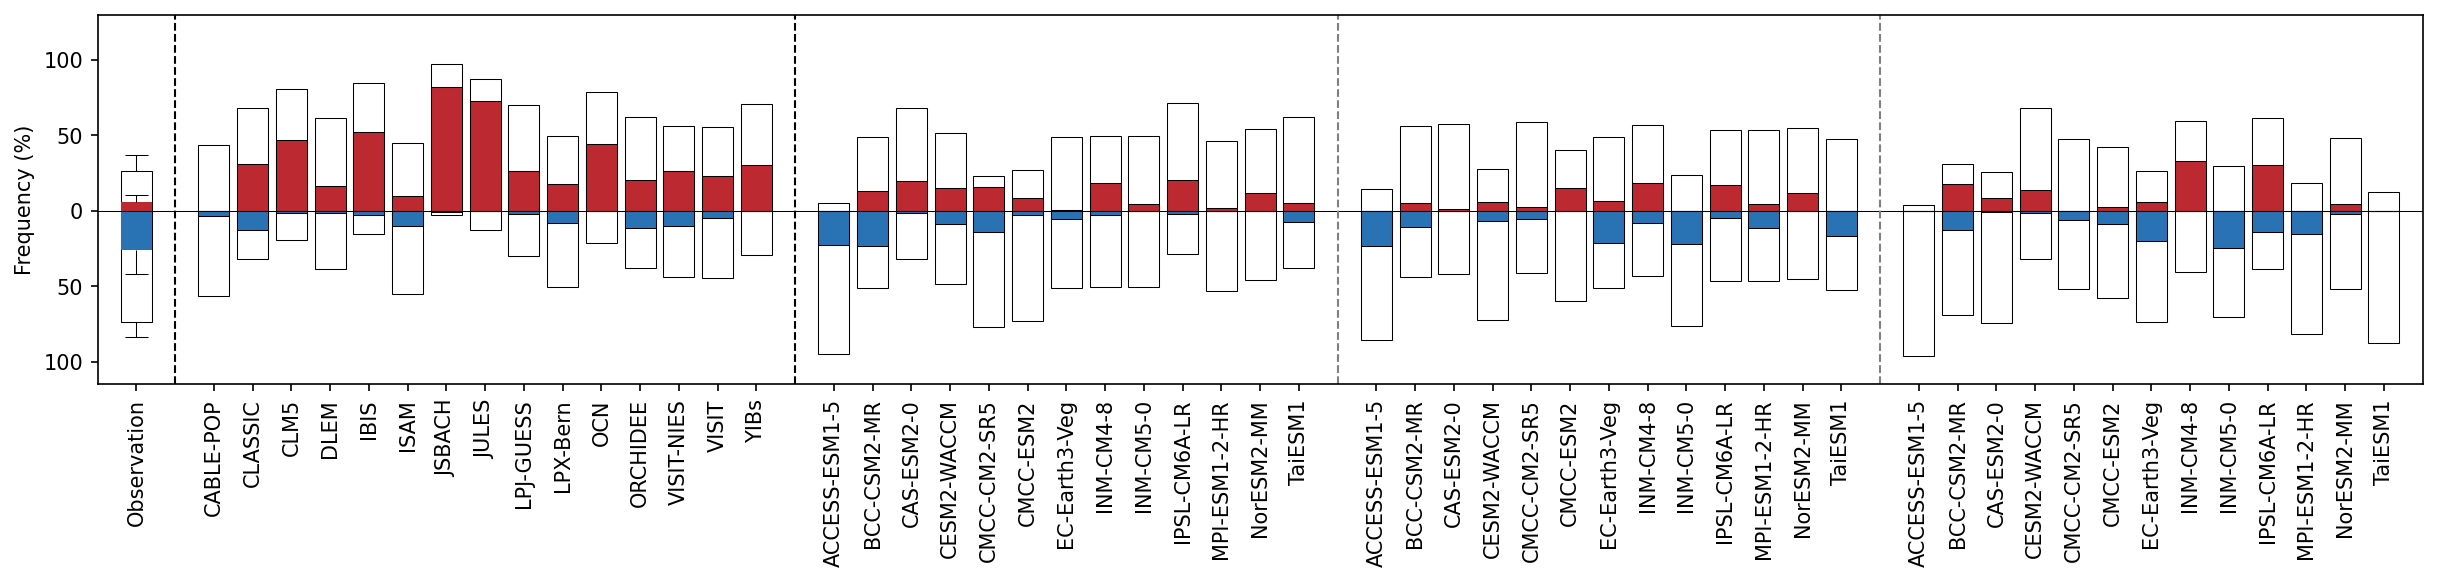

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from phenology.utils import dfsummary



def calculate_mean_std(data):
   """
   Calculate the mean and standard deviation of a given dataset.

   Args:
       data (list or np.array): A list or numpy array containing the data points.

   Returns:
       tuple: A tuple containing the mean and standard deviation of the input data.
              The first element is the mean, and the second element is the standard deviation.
   """
   # Calculate the mean using numpy
   mean = np.mean(data)
   # Calculate the standard deviation using numpy
   std = np.std(data)
   return mean, std



def calculate_correlation_stats(data_list):
   """
   Calculate the mean and standard deviation of the positive and negative correlation
   ratios in multiple dataframes in the input data list.

   Args:
       data_list (list): A list containing multiple dataframes.

   Returns:
       p1_mean (float): Mean of the positive correlation ratio for the entire dataset.
       p2_mean (float): Mean of the positive correlation ratio with p-value < 0.05.
       n1_mean (float): Mean of the negative correlation ratio for the entire dataset.
       n2_mean (float): Mean of the negative correlation ratio with p-value < 0.05.
       p1_std (float): Standard deviation of the positive correlation ratio for the entire dataset.
       p2_std (float): Standard deviation of the positive correlation ratio with p-value < 0.05.
       n1_std (float): Standard deviation of the negative correlation ratio for the entire dataset.
       n2_std (float): Standard deviation of the negative correlation ratio with p-value < 0.05.
   """
   # Use list comprehension to obtain data and calculate mean and standard deviation
   p1_list = [dfsummary(df, oprint=False)[0] * 100 for df in data_list]
   p2_list = [dfsummary(df, oprint=False)[1] * 100 for df in data_list]
   n1_list = [dfsummary(df, oprint=False)[3] * 100 for df in data_list]
   n2_list = [dfsummary(df, oprint=False)[4] * 100 for df in data_list]

   # Calculate the mean and standard deviation for each list
   p1_mean, p1_std = calculate_mean_std(p1_list)
   p2_mean, p2_std = calculate_mean_std(p2_list)
   n1_mean, n1_std = calculate_mean_std(n1_list)
   n2_mean, n2_std = calculate_mean_std(n2_list)

   return p1_mean, p2_mean, n1_mean, n2_mean, p1_std, p2_std, n1_std, n2_std



def plt_regress_result(obs_list, data_list):
    obs_df_list = [pd.read_csv(f) for f in obs_list]
    p1_mean, p2_mean, n1_mean, n2_mean, p1_std, p2_std, n1_std, n2_std = calculate_correlation_stats(obs_df_list)

    plt.subplots(nrows=1, ncols=1, figsize=(20, 3.2), dpi=150)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12

    # 设置Observation
    def errbar(x, y, error, x_linewidth=0.5, y_linewidth=0.5, color='black'):
        plt.hlines(y=y+error, xmin=-0.3, xmax=0.3, color=color, linewidth=x_linewidth)
        plt.vlines(x=x, ymin=y, ymax=y+error, color=color, linewidth=y_linewidth)


    # 绘制Observation
    plt.bar(0, p1_mean, width=0.8,  color='#00000000', edgecolor='black', linewidth=0.5)
    plt.bar(0, -n1_mean, width=0.8, color='#00000000', edgecolor='black', linewidth=0.5)
    plt.bar(0, p2_mean, width=0.8, color=(189/255, 41/255, 49/255))
    plt.bar(0, -n2_mean, width=0.8, color=(41/255, 115/255, 181/255))
    errbar(0, p1_mean, p1_std, x_linewidth=0.5, y_linewidth=0.5, color='black')
    errbar(0, -n1_mean, -n1_std, x_linewidth=0.5, y_linewidth=0.5, color='black')
    errbar(0, p2_mean, p2_std, x_linewidth=0.5, y_linewidth=0.5, color='black')
    errbar(0, -n2_mean, -n2_std, x_linewidth=0.5, y_linewidth=0.5, color='black')

    plt.axhline(y=0, color='black', linewidth=0.5)
    plt.axvline(x=1, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x=17, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x=31, color='gray', linestyle='dashed', linewidth=1)
    plt.axvline(x=45, color='gray', linestyle='dashed', linewidth=1)
    
    
    for x_pos, data_file in enumerate(data_list):
        x_pos = x_pos + 1
        bio_res = pd.read_csv(data_file)

        if 'coef_tree_species_num' in bio_res.columns:
            bio_res['r'] = bio_res['coef_tree_species_num']
            bio_res['p-val'] = bio_res['pval_tree_species_num']

        res_0p05 = bio_res[bio_res['p-val'] < 0.05]

        # 计算正负值的占比
        total_values = len(bio_res)
        p1 = (len(bio_res[bio_res['r'] > 0])/ total_values) * 100
        n1 = -(len(bio_res[bio_res['r'] < 0])/ total_values) * 100
        p2 = (len(res_0p05[res_0p05['r'] > 0])/ total_values) * 100
        n2 = -(len(res_0p05[res_0p05['r'] < 0])/ total_values) * 100
        x_pos += sum(1 for threshold in [0, 15, 28, 41] if x_pos > threshold)

        # 绘制条形图
        plt.bar(x_pos, p1, width=0.8, color='#00000000', edgecolor='black', linewidth=0.5, label='Positive')
        plt.bar(x_pos, n1, width=0.8, color='#00000000', edgecolor='black', linewidth=0.5, label='Negative')
        plt.bar(x_pos, p2, width=0.8, color=(189/255, 41/255, 49/255), edgecolor='black', linewidth=0.5, label='Positive')
        plt.bar(x_pos, n2, width=0.8, color=(41/255, 115/255, 181/255), edgecolor='black', linewidth=0.5, label='Negative')


    x_ticks = [x for x in range(0, len(data_list)+5) if x not in [1, 17, 31, 45]]
    x_labels = ['Observation'] + [os.path.basename(i).split('.')[0].split('_')[-1] for i in data_list]
    
    plt.ylim((-115, 130))
    plt.xlim((-1, len(data_list)+5))
    plt.xticks(x_ticks, x_labels, rotation=90)
    plt.yticks([-100, -50,  0, 50, 100], [100, 50,  0, 50, 100])
    plt.ylabel(f'Frequency (%)')
    plt.show()

    
    
if __name__ == '__main__':
    obs_list = glob('./Result_v2/gwr/Observation-old/*.csv')
    tre_list = glob('./Result_v2/gwr/Trendy/*.csv')
    ssp126_list = glob('./Result_v2/gwr/cmip6/ssp126_*.csv')
    ssp245_list = glob('./Result_v2/gwr/cmip6/ssp245_*.csv')
    ssp585_list = glob('./Result_v2/gwr/cmip6/ssp585_*.csv')
    data_list = tre_list + ssp126_list + ssp245_list + ssp585_list

    plt_regress_result(obs_list, data_list)